# Please **DO NOT** run any cells as everything (all final images, graphs, etc. are preloaded)

# Section 0 - Preface for Imports, Data Handling, & Methodologies 

## Section 0.1 Preface for Write-Up Interpretation

For the remainder of this notebook, each part 1) and 2) will be answered in line with notation for the following block of code to show:

1. A brief statement (~paragraph) of what was done to answer the question (narratively explaining what you did in code to answer the question, at a high level).

2. A brief statement (~paragraph) as to why this was done (why the question was answered in this way, not by doing something else. Some kind of rationale as to why you did x and not y or z to answer the question – why is what you did a suitable approach?).

For 3) and 4) the findings and interpretations will be provided in Results & Discussions for each question (model(s)) we ran.

## Section 0.2 Imports & Installation of Packages and Libraries

This notebook was created using Google Colab and needs the following packages to run

In [1]:
!pip install eli5
!pip install graphviz
!pip install scikit-optimize
!pip install tune_sklearn
!pip install scikit-plot
!pip install statsmodels

  Using cached tensorboardX-2.5-py2.py3-none-any.whl (125 kB)
  Attempting uninstall: tensorboardX
    Found existing installation: tensorboardX 1.8
    Uninstalling tensorboardX-1.8:


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\tensorboardx-1.8.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



In [49]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import Softmax
import torch.optim as optim

import scipy.stats as st

# import statsmodels.api as sm ## Need revision for Windows use
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import zscore

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree, ensemble, metrics, calibration
from sklearn.svm import SVC, LinearSVC

from IPython import display

from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5

from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt import BayesSearchCV

from tune_sklearn import TuneSearchCV, TuneGridSearchCV
import ray.tune as tune

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import scikitplot as skplt
import seaborn as sns; sns.set_theme(color_codes=True)
import graphviz
import colorcet as cc

## Section 0.3

Checking the availability of CUDA for PyTorch on this Device and if available, use it for Adam Gradient Descent

In [3]:
print(f'CUDA is Available: {torch.cuda.is_available()}')
print(f'Current CUDA Device: {torch.cuda.current_device()}')
print(f'CUDA Device Location: {torch.cuda.device(0)}')
print(f'CUDA Device Count: {torch.cuda.device_count()}')
print(f'CUDA Device Name: {torch.cuda.get_device_name(0)}, {torch.cuda.get_device_name(1)}')

CUDA is Available: True
Current CUDA Device: 0
CUDA Device Location: <torch.cuda.device object at 0x000001780A7F8910>
CUDA Device Count: 2
CUDA Device Name: NVIDIA TITAN RTX, NVIDIA TITAN RTX


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')
print(f'Currently Using Device: {device}')

Currently Using Device: cuda:0


## Section 0.4 Data Handling

Below, we check the presence of `NA`'s in the dataframe and afterwards, output a description of the dataframe, including `'all'` columns

In [1]:
df = pd.read_csv('diabetes.csv')

pd.set_option('display.max_columns', None)
print(f'Dataframe contains any NA values: {df.isnull().values.any()}')
df.describe(include='all')

NameError: name 'pd' is not defined

Viewing the entries of the first 10 rows of this new dataframe:

In [6]:
df.head(10)

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,0,1,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,1,11,5,4,8
5,0,1,1,25,1,0,0,1,1,1,0,1,0,2,0,2,0,2,10,6,8,2
6,0,1,0,30,1,0,0,0,0,0,0,1,0,3,0,14,0,1,9,6,7,4
7,0,1,1,25,1,0,0,1,0,1,0,1,0,3,0,0,1,1,11,4,4,7
8,1,1,1,30,1,0,1,0,1,1,0,1,0,5,30,30,1,1,9,5,1,12
9,0,0,0,24,0,0,0,0,0,1,0,1,0,2,0,0,0,2,8,4,3,12


## Section 0.5 Standardization & Normalization

For this dataset, I have opted to standardize (Z-score) all columns not associated with cardinally organized categorical variables or dummy/one-hot coded variables. The meaning of standardization in this analysis will entail subtracting every element of a column by the mean of that column, then dividing by the mean of the column:

$$ \textrm{Z-Score: }\frac{\vec{X} - \mu_{X}}{\sigma_{X}} $$

Variables identified as being close enough to being continuous predictors are: `BMI`, `GeneralHealth`, `MentalHealth`, and `PhysicalHealth`. I will then call the `StandardScalar().fit_transform()` function on the data to scale, and transform (standardize) the variables as shown by the equation above. This will then be the fdataframe to be executed upon in all further analysis.

In [7]:
continuous_predictors = ['BMI', 'GeneralHealth', 'MentalHealth','PhysicalHealth']

for item in continuous_predictors:
    df[[item]] = StandardScaler().fit_transform(df[[item]])

In [8]:
label = df[['Diabetes']]
label

,Diabetes
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,1
253677,0
253678,0


### View a correlation matrix of the data

In [9]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(10)

C:\Users\sunny\AppData\Local\Temp\ipykernel_23412\3389594757.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(10)


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
Diabetes,1.0000000000,0.2631287899,0.2002761919,0.2168430602,0.0607885056,0.1058160673,0.1772822578,-0.1181331149,-0.0407792281,-0.0565841371,-0.0570562561,0.0162551395,0.0314327634,0.2935690631,0.0693150826,0.1713367004,0.2183443519,0.0314299980,0.1774418722,-0.1244559692,-0.1639187868,-0.0001971111
HighBP,0.2631287899,1.0000000000,0.2981992951,0.2137481202,0.0969914670,0.1295749130,0.2093612107,-0.1252668662,-0.0405546586,-0.0612661653,-0.0039715740,0.0384247689,0.0173579836,0.3005296306,0.0564559169,0.1612115712,0.2236184659,0.0522069607,0.3444523298,-0.1413579336,-0.1712345812,-0.0026294552
HighChol,0.2002761919,0.2981992951,1.0000000000,0.1067220822,0.0912993573,0.0926200745,0.1807653549,-0.0780461859,-0.0408590813,-0.0398736072,-0.0115425186,0.0422298622,0.0133101632,0.2084255497,0.0620691538,0.1217505276,0.1446715380,0.0312053301,0.2723182263,-0.0708018870,-0.0854593146,0.0010516002
BMI,0.2168430602,0.2137481202,0.1067220822,1.0000000000,0.0138044667,0.0201526605,0.0529042565,-0.1472936336,-0.0875181207,-0.0622751936,-0.0487362755,-0.0184707866,0.0582062901,0.2391853727,0.0853101592,0.1211411074,0.1970777603,0.0429503033,-0.0366176352,-0.1039320221,-0.1000687103,-0.0019316871
Smoker,0.0607885056,0.0969914670,0.0912993573,0.0138044667,1.0000000000,0.0611726747,0.1144412177,-0.0874011625,-0.0776658386,-0.0306777098,0.1016186870,-0.0232508032,0.0489458235,0.1631430671,0.0921964744,0.1164597144,0.1224632146,0.0936623614,0.1206410845,-0.1619552554,-0.1239372292,0.0009745959
Stroke,0.1058160673,0.1295749130,0.0926200745,0.0201526605,0.0611726747,1.0000000000,0.2030019400,-0.0691514156,-0.0133893530,-0.0411242247,-0.0169503303,0.0087759254,0.0348041063,0.1779422602,0.0701718117,0.1489441689,0.1765669170,0.0029782884,0.1269736985,-0.0760085572,-0.1285985781,-0.0019328208
Myocardial,0.1772822578,0.2093612107,0.1807653549,0.0529042565,0.1144412177,0.2030019400,1.0000000000,-0.0872989869,-0.0197903479,-0.0391674090,-0.0289905157,0.0187341863,0.0309997048,0.2583834087,0.0646212920,0.1816975358,0.2127086953,0.0860955081,0.2216176324,-0.0995999154,-0.1410112314,-0.0012315553
PhysActivity,-0.1181331149,-0.1252668662,-0.0780461859,-0.1472936336,-0.0874011625,-0.0691514156,-0.0872989869,1.0000000000,0.1427558627,0.1531495702,0.0123922362,0.0355047365,-0.0616383873,-0.2661856237,-0.1255870881,-0.2192295222,-0.2531740075,0.0324816858,-0.0925106333,0.1996580572,0.1985394551,-0.0008418517
Fruit,-0.0407792281,-0.0405546586,-0.0408590813,-0.0875181207,-0.0776658386,-0.0133893530,-0.0197903479,0.1427558627,1.0000000000,0.2543422444,-0.0352877329,0.0315439188,-0.0442426894,-0.1038541713,-0.0682173751,-0.0446333245,-0.0483516746,-0.0911748653,0.0645472165,0.1101870969,0.0799293134,-0.0022553916
Vegetables,-0.0565841371,-0.0612661653,-0.0398736072,-0.0622751936,-0.0306777098,-0.0411242247,-0.0391674090,0.1531495702,0.2543422444,1.0000000000,0.0210644811,0.0295838169,-0.0322317050,-0.1230663300,-0.0588835533,-0.0642903271,-0.0805057167,-0.0647651561,-0.0097711976,0.1543292615,0.1510869442,-0.0007323915


## Section 0.6 Label View

In this section, we will view the output of the labels and take into account disparity in outcome.

We can see from the outcome that the classes are highly skewed to the negative and would require the use of f1 scores to disting predictive capability under this skewness.

In [10]:
one_count = len(label.loc[(label['Diabetes'] == 1)])
zero_count = len(label.loc[(label['Diabetes'] == 0)])
print(f'Number of positive class: {one_count}')
print(f'Number of negative class: {zero_count}')

Number of positive class: 35346
Number of negative class: 218334


# Question 1

Build and train a Perceptron (one input layer, one output layer, no hidden layers and no activation functions) to classify diabetes from the rest of the dataset. What is the AUC of this model?

## Section 1.0 Scikit Learn `Perceptron` Fitting & Train-Test Split

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability.

Next, we utilize `sklearn.linear_model`'s `Perceptron` class to create a Perceptron fitting the number of input features and output values (one, given linear output).

In [11]:
X = df.loc[:, 'HighBP':]
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [12]:
perceptron = Perceptron(random_state=1234)
perceptron.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Perceptron(random_state=1234)

## Section 1.1 `CalibratedClassifierCV` Fitting of `Perceptron` Class

Below we use the `CalibratedClassifierCV` class to make it possible to both `predict` the outputs of a given `y_test` set of unseen data, and `predict_proba` the probabilities of each new, unseen feature set `y_test`.

Following from the calculated `predict_proba` variable, we use `metrics.roc_curve` to output the AUC ROC of our model.

0.7051916832377519


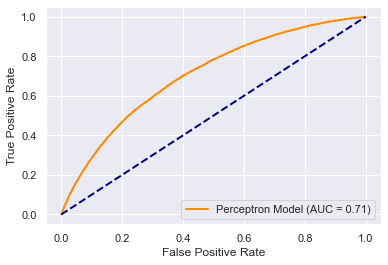

In [13]:
cal_perceptron = calibration.CalibratedClassifierCV(base_estimator=perceptron, method='sigmoid', n_jobs=-1, cv='prefit')
cal_perceptron.fit(X_test, y_test)

perceptron_pred = cal_perceptron.predict(X_test)
perceptron_proba = cal_perceptron.predict_proba(X_test)[:,1]

fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=perceptron_proba, pos_label=1)
perceptron_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=perceptron_auc,
                                  estimator_name='Perceptron Model')

print(perceptron_auc)
display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 1.2 `PermutationImportance` of Features

Next, we use the `PermutationImportance` package from the `eli5` library to calculate the permutated importance of individual features. The theory goes that for every feature, (for k=5 cross-fold validation) the individual rows (for that feature column ONLY) are shuffled (permutated) randomly. 

This will give the intuition of making the feature invalid (as close to removing as possible without actually removing it). The drop in scores entail the importance of the feature to the overall performance of the model. Finally, a $\pm$ value is provided from the extremes of the 5-fold cross-validation.

In [14]:
perm1 = PermutationImportance(estimator=perceptron, random_state=1234)
perm1.fit(X_test, y_test)
eli5.show_weights(perm1, feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0010 ± 0.0003,GeneralHealth
0.0006 ± 0.0001,HighChol
0.0003 ± 0.0002,HighBP
0.0002 ± 0.0001,Myocardial
0.0000 ± 0.0003,BMI
0.0000 ± 0.0000,HasHealthcare
0.0000 ± 0.0000,HeavyDrinker
0.0000 ± 0.0001,MentalHealth
-0.0000 ± 0.0000,HardToClimbStairs
-0.0000 ± 0.0001,Stroke


## Section 1.3 Results & Discussion

From training the model we determine an AUC of 0.70519, and given a perceptron without an activation function the same as a linear regression model, this is a good AUC score to obtain.

# Question 2

Build and train a feedforward neural network with at least one hidden layer to classify diabetes from the rest of the dataset. Make sure to try different numbers of hidden layers and different activation functions (at a minimum reLU and sigmoid). Doing so: How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron?

## Section 2.0 Feedforward `MLPClassifier` Fitting & Train-Test Split

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability.

Next, we utilize `sklearn.neural_network`'s `MLPClassifier` class to create a Multilayer Perceptron (Feedforward Neural Network) fitting the number of input features and output values (one, given linear output).

We create a total of 12 models, one for each cardinal product between the number of hidden layers: `[1, 2, 3]` and the type of activation to use: `['identity', 'relu', 'logistic', 'tanh']`. Every model will have `hidden_layer_size` = 64. For each model, we define an entry in a dictionary, `fnn_models2` that, as the `key` contains the model name, and as the `value` contains the instantiated & fit model.

In [15]:
X = df.loc[:, 'HighBP':]
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [16]:
hidden_layers = [1, 2, 3]
# hidden_size = [2, 4, 8, 16, 32, 64, 128] ## Opted not to tunr for hidden layer sizes
activation = ['identity', 'relu', 'logistic', 'tanh']

fnn_models2 = {}
model_name = lambda x: f'fnn_{x[0]}_{x[1]}'

for num in hidden_layers:
  for function in activation:
    name = [function, num]
    if num == 1:
      fnn = MLPClassifier(hidden_layer_sizes=(64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn_models2[model_name(name)] = fnn
    if num == 2:
      fnn = MLPClassifier(hidden_layer_sizes=(64,64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn_models2[model_name(name)] = fnn
    if num == 3:
      fnn = MLPClassifier(hidden_layer_sizes=(64,64,64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn_models2[model_name(name)] = fnn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

## Section 2.1 `CalibratedClassifierCV` Fitting of `MLPClassifier` Class

Below we use the `CalibratedClassifierCV` class to make it possible to both `predict` the outputs of a given `y_test` set of unseen data, and `predict_proba` the probabilities of each new, unseen feature set `y_test`.

We use the dictionary `fnn_cals2` to store the output of every `CalibratedClassifierCV` as the `value` to the `key` of the same name as the `fnn_models2` dictionary.

Following from each calculated `predict_proba` variable stored in the `fnn_cals2` dictionary, we use `metrics.roc_curve` to output the AUC ROC of each model.

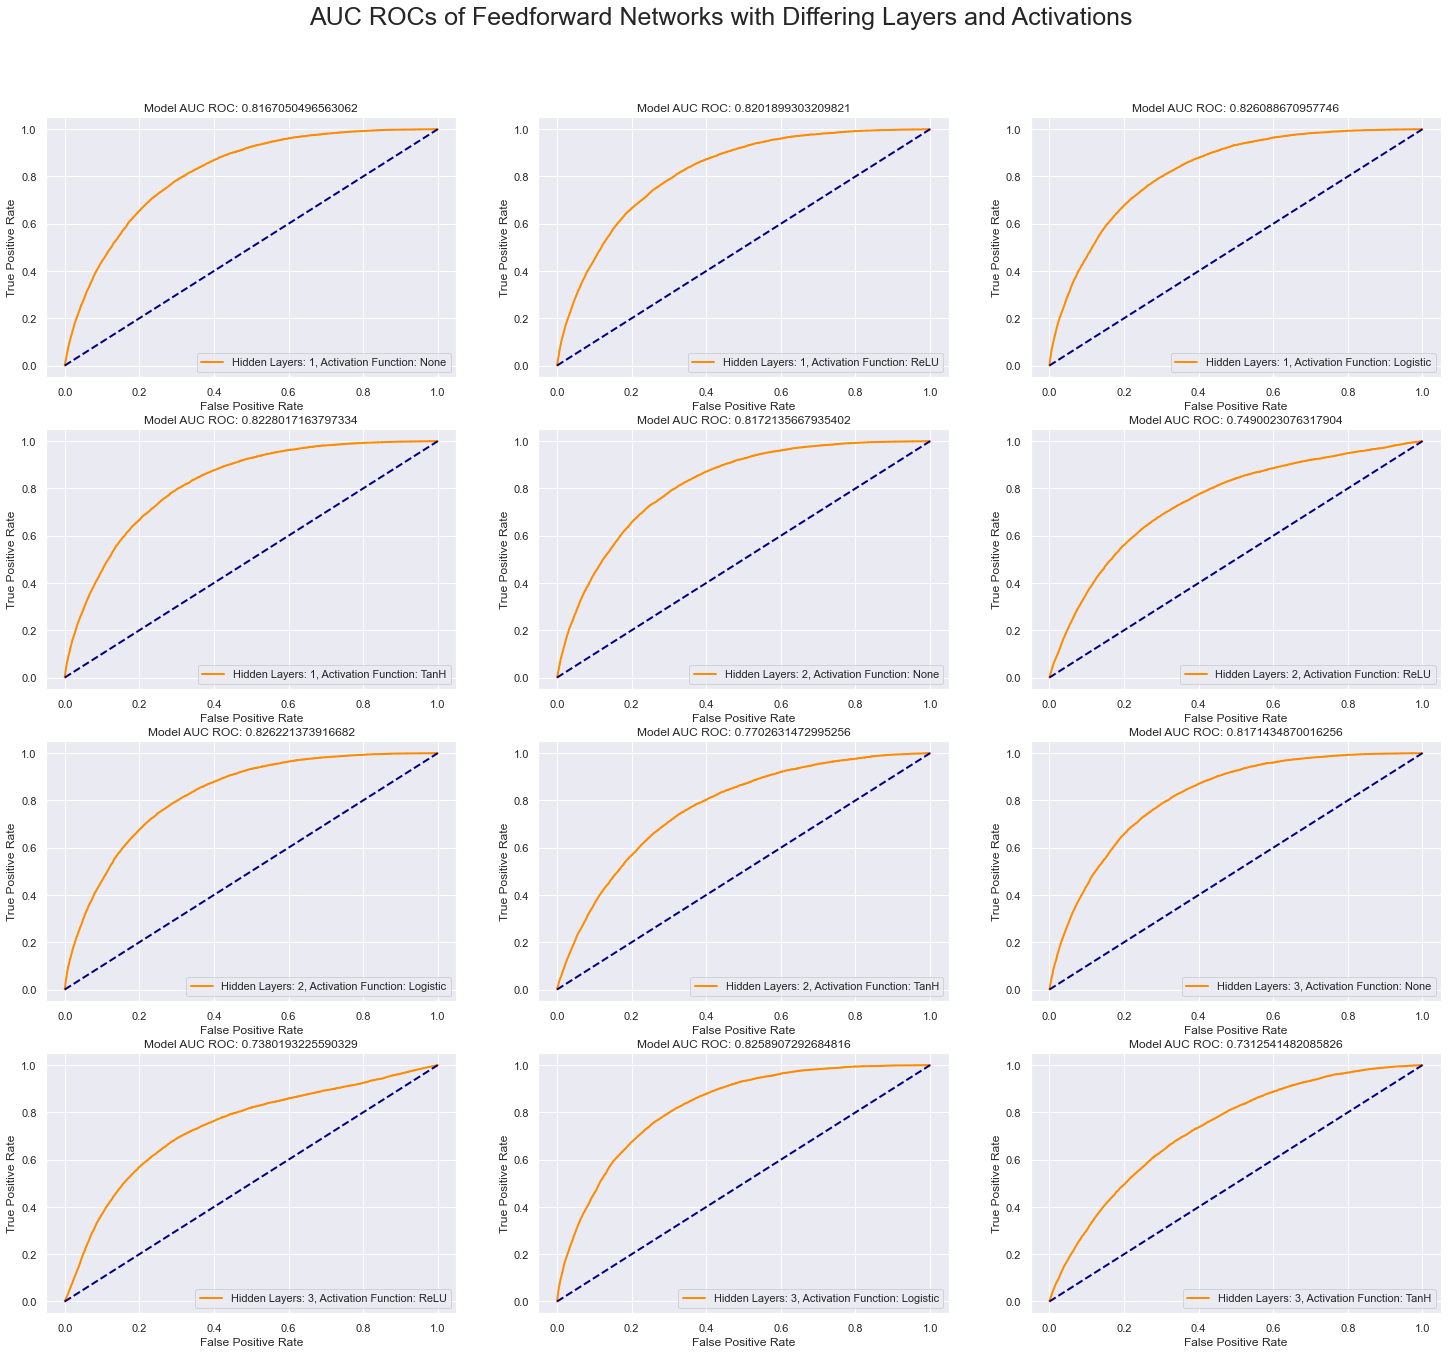

In [17]:
fnn_cals2 = {}
for key, value in fnn_models2.items():
  cal_fnn = calibration.CalibratedClassifierCV(base_estimator=value, method='sigmoid', n_jobs=-1, cv='prefit')
  cal_fnn.fit(X_test, y_test)

  fnn_pred = cal_fnn.predict(X_test)
  fnn_proba = cal_fnn.predict_proba(X_test)[:,1]

  fnn_cals2[key] = (fnn_pred, fnn_proba)

fnn2_aucname_map = {'fnn_identity_1': 'Hidden Layers: 1, Activation Function: None',
                   'fnn_identity_2': 'Hidden Layers: 2, Activation Function: None',
                   'fnn_identity_3': 'Hidden Layers: 3, Activation Function: None',    
                   'fnn_relu_1': 'Hidden Layers: 1, Activation Function: ReLU',
                   'fnn_relu_2': 'Hidden Layers: 2, Activation Function: ReLU',
                   'fnn_relu_3': 'Hidden Layers: 3, Activation Function: ReLU',
                   'fnn_logistic_1': 'Hidden Layers: 1, Activation Function: Logistic',
                   'fnn_logistic_2': 'Hidden Layers: 2, Activation Function: Logistic',
                   'fnn_logistic_3': 'Hidden Layers: 3, Activation Function: Logistic',
                   'fnn_tanh_1': 'Hidden Layers: 1, Activation Function: TanH',
                   'fnn_tanh_2': 'Hidden Layers: 2, Activation Function: TanH',
                   'fnn_tanh_3': 'Hidden Layers: 3, Activation Function: TanH'}

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25,22))
fig.suptitle('AUC ROCs of Feedforward Networks with Differing Layers and Activations', fontsize=25, y=0.95)

fnn_cal2_keys = fnn_cals2.keys()

for key, ax in zip(fnn_cal2_keys, axs.ravel()):
    
    pred_proba = fnn_cals2[key][1]

    fpr, tpr, _ = metrics.roc_curve(y_true=y_test, y_score=pred_proba, pos_label=1)
    auc = metrics.auc(x=fpr, y=tpr)

    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
                                      estimator_name=f'{fnn2_aucname_map[key]}')
    
    display.plot(color='darkorange', lw=2, ax=ax)
    ax.set_title(f'Model AUC ROC: {auc}')
    ax.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")

## Section 2.2 `PermutationImportance` of Features

Next, we use the `PermutationImportance` package from the `eli5` library to calculate the permutated importance of individual features. The theory goes that for every feature, (for k=5 cross-fold validation) the individual rows (for that feature column ONLY) are shuffled (permutated) randomly. 

We will create a dictionary `fnn2_perm` full of `PermurationImportance` objects. Each will correspond to an individual model in `fnn_models2`.

This will give the intuition of making the feature invalid (as close to removing as possible without actually removing it). The drop in scores entail the importance of the feature to the overall performance of the model. Finally, a $\pm$ value is provided from the extremes of the 5-fold cross-validation.

In [18]:
fnn2_perm = {}
for key, value in fnn_models2.items():
    fnn = value
    
    perm2 = PermutationImportance(estimator=fnn, random_state=1234)
    perm2.fit(X_test, y_test)
    
    fnn2_perm[key] = perm2

In [19]:
eli5.show_weights(fnn2_perm['fnn_identity_1'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0048 ± 0.0004,BMI
0.0039 ± 0.0006,GeneralHealth
0.0019 ± 0.0005,HighBP
0.0017 ± 0.0006,HighChol
0.0008 ± 0.0006,AgeBracket
0.0004 ± 0.0001,Myocardial
0.0003 ± 0.0004,BiologicalSex
0.0002 ± 0.0002,IncomeBracket
0.0002 ± 0.0002,HardToClimbStairs
0.0002 ± 0.0000,PhysActivity


In [20]:
eli5.show_weights(fnn2_perm['fnn_identity_2'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0057 ± 0.0003,BMI
0.0045 ± 0.0005,GeneralHealth
0.0015 ± 0.0005,HighBP
0.0015 ± 0.0007,HighChol
0.0008 ± 0.0007,AgeBracket
0.0004 ± 0.0003,BiologicalSex
0.0002 ± 0.0002,HeavyDrinker
0.0001 ± 0.0001,HardToClimbStairs
0.0000 ± 0.0003,PhysActivity
-0.0000 ± 0.0002,Zodiac


In [21]:
eli5.show_weights(fnn2_perm['fnn_identity_3'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0063 ± 0.0005,BMI
0.0051 ± 0.0007,GeneralHealth
0.0020 ± 0.0006,HighBP
0.0015 ± 0.0006,HighChol
0.0011 ± 0.0006,AgeBracket
0.0005 ± 0.0003,BiologicalSex
0.0002 ± 0.0003,HeavyDrinker
0.0002 ± 0.0001,HardToClimbStairs
0.0002 ± 0.0003,PhysicalHealth
0.0001 ± 0.0001,MentalHealth


In [22]:
eli5.show_weights(fnn2_perm['fnn_relu_1'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0077 ± 0.0002,GeneralHealth
0.0066 ± 0.0004,BMI
0.0024 ± 0.0003,HighChol
0.0022 ± 0.0007,HighBP
0.0020 ± 0.0008,AgeBracket
0.0009 ± 0.0002,HardToClimbStairs
0.0007 ± 0.0002,PhysicalHealth
0.0003 ± 0.0004,EducationBracket
0.0002 ± 0.0002,HeavyDrinker
0.0002 ± 0.0005,Fruit


In [23]:
eli5.show_weights(fnn2_perm['fnn_relu_2'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0080 ± 0.0004,GeneralHealth
0.0055 ± 0.0017,BMI
0.0039 ± 0.0010,AgeBracket
0.0025 ± 0.0006,PhysicalHealth
0.0013 ± 0.0005,HighChol
0.0011 ± 0.0008,BiologicalSex
0.0011 ± 0.0006,Smoker
0.0009 ± 0.0010,MentalHealth
0.0007 ± 0.0012,IncomeBracket
0.0007 ± 0.0005,HardToClimbStairs


In [24]:
eli5.show_weights(fnn2_perm['fnn_relu_3'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0124 ± 0.0010,GeneralHealth
0.0083 ± 0.0013,BMI
0.0059 ± 0.0013,AgeBracket
0.0027 ± 0.0008,PhysicalHealth
0.0024 ± 0.0010,IncomeBracket
0.0022 ± 0.0012,HighChol
0.0019 ± 0.0005,HardToClimbStairs
0.0015 ± 0.0008,EducationBracket
0.0014 ± 0.0011,BiologicalSex
0.0014 ± 0.0006,HighBP


In [25]:
eli5.show_weights(fnn2_perm['fnn_logistic_1'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0065 ± 0.0009,BMI
0.0058 ± 0.0004,GeneralHealth
0.0023 ± 0.0005,HighChol
0.0016 ± 0.0006,AgeBracket
0.0015 ± 0.0005,HighBP
0.0008 ± 0.0002,BiologicalSex
0.0005 ± 0.0001,HardToClimbStairs
0.0003 ± 0.0002,HeavyDrinker
0.0003 ± 0.0003,IncomeBracket
0.0003 ± 0.0004,Myocardial


In [26]:
eli5.show_weights(fnn2_perm['fnn_logistic_2'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0072 ± 0.0004,GeneralHealth
0.0070 ± 0.0007,BMI
0.0023 ± 0.0005,HighChol
0.0022 ± 0.0006,HighBP
0.0020 ± 0.0005,AgeBracket
0.0005 ± 0.0002,HardToClimbStairs
0.0005 ± 0.0002,BiologicalSex
0.0004 ± 0.0002,HeavyDrinker
0.0003 ± 0.0003,IncomeBracket
0.0003 ± 0.0003,PhysicalHealth


In [27]:
eli5.show_weights(fnn2_perm['fnn_logistic_3'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0069 ± 0.0004,GeneralHealth
0.0067 ± 0.0009,BMI
0.0024 ± 0.0006,HighChol
0.0021 ± 0.0006,HighBP
0.0021 ± 0.0006,AgeBracket
0.0004 ± 0.0005,IncomeBracket
0.0004 ± 0.0001,HeavyDrinker
0.0004 ± 0.0002,BiologicalSex
0.0002 ± 0.0003,Myocardial
0.0002 ± 0.0003,PhysicalHealth


In [28]:
eli5.show_weights(fnn2_perm['fnn_tanh_1'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0071 ± 0.0002,GeneralHealth
0.0068 ± 0.0008,BMI
0.0025 ± 0.0006,AgeBracket
0.0020 ± 0.0003,HighChol
0.0012 ± 0.0006,HighBP
0.0006 ± 0.0002,BiologicalSex
0.0006 ± 0.0004,IncomeBracket
0.0006 ± 0.0003,Myocardial
0.0005 ± 0.0006,Fruit
0.0005 ± 0.0002,HardToClimbStairs


In [29]:
eli5.show_weights(fnn2_perm['fnn_tanh_2'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0079 ± 0.0017,GeneralHealth
0.0049 ± 0.0007,BMI
0.0036 ± 0.0014,AgeBracket
0.0018 ± 0.0008,PhysicalHealth
0.0014 ± 0.0007,BiologicalSex
0.0009 ± 0.0005,HighBP
0.0007 ± 0.0005,Smoker
0.0007 ± 0.0004,PhysActivity
0.0007 ± 0.0008,HighChol
0.0006 ± 0.0012,MentalHealth


In [30]:
eli5.show_weights(fnn2_perm['fnn_tanh_3'], feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0143 ± 0.0015,GeneralHealth
0.0067 ± 0.0015,BMI
0.0054 ± 0.0022,AgeBracket
0.0023 ± 0.0012,BiologicalSex
0.0022 ± 0.0008,Myocardial
0.0022 ± 0.0009,IncomeBracket
0.0016 ± 0.0020,HighChol
0.0015 ± 0.0017,HighBP
0.0015 ± 0.0013,PhysicalHealth
0.0009 ± 0.0011,PhysActivity


## Section 2.3 Results & Discussion

From training 12 different models with different combinations of activation functions and number of layers, and taking al ook at the AUC ROC of each model, we see that a feedforward neural network with different number of layers improves the AUC ROC marginally, but the experiment controlled for the size of each hidden layer (setting each at 128), so dicrepencies may exist due to that.

Furthermore, a general pattern emerged of each dimensionalization of hidden layers having `logistic` > `Tanh` > `ReLU` > `identity` in AUC ROC performance (with general increases in the number of hidden layers increasing performance marginally).

# Question 3

Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from the rest of the dataset. Given the nature of this dataset, is there a benefit of using a CNN or RNN for the classification?

## Section 3.0 Feedforward `MLPClassifier` Fitting & Train-Test Split

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability.

Next, we utilize `sklearn.neural_network`'s `MLPClassifier` class to create a Multilayer Perceptron (Feedforward Neural Network) fitting the number of input features and output values. This model will have 2 hidden layers, with `hidden_layer_size` = 128 for each layer.

In [31]:
X = df.loc[:, 'HighBP':]
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Section 3.1 `CalibratedClassifierCV` Fitting of `MLClassifier` Class

Below we use the `CalibratedClassifierCV` class to make it possible to both `predict` the outputs of a given `y_test` set of unseen data, and `predict_proba` the probabilities of each new, unseen feature set `y_test`.

We use the variable `cal_dnn3` to store the output of the `CalibratedClassifierCV`.

Following from each calculated `predict_proba` variable stored in the `dnn3_proba` dictionary, we use `metrics.roc_curve` to output the AUC ROC of the model.

In [32]:
function = 'relu'

dnn3 = MLPClassifier(hidden_layer_sizes=(128,128,), random_state=1234, activation=function)
dnn3.fit(X_train, y_train)

cal_dnn3 = calibration.CalibratedClassifierCV(base_estimator=dnn3, method='sigmoid', n_jobs=-1, cv='prefit')
cal_dnn3.fit(X_test, y_test)

dnn3_pred = cal_dnn3.predict(X_test)
dnn3_proba = cal_dnn3.predict_proba(X_test)[:,1]

fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=dnn3_proba, pos_label=1)
dnn3_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=dnn3_auc,
                                  estimator_name='Deep Neural Network Model')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7490023076317904


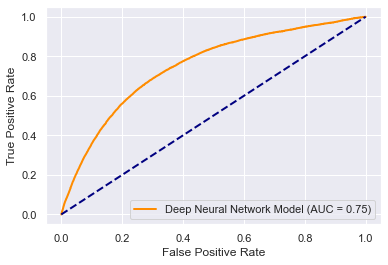

In [33]:
print(dnn3_auc)
display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 3.2 `PermutationImportance` of Features

Next, we use the `PermutationImportance` package from the `eli5` library to calculate the permutated importance of individual features. The theory goes that for every feature, (for k=5 cross-fold validation) the individual rows (for that feature column ONLY) are shuffled (permutated) randomly. The model we use is `dnn3` as defined and processed above.

This will give the intuition of making the feature invalid (as close to removing as possible without actually removing it). The drop in scores entail the importance of the feature to the overall performance of the model. Finally, a $\pm$ value is provided from the extremes of the 5-fold cross-validation.

In [34]:
perm3 = PermutationImportance(estimator=dnn3, random_state=1234)
perm3.fit(X_test, y_test)
eli5.show_weights(perm3, feature_names=X.columns.tolist(), top=100)

Weight,Feature
0.0080 ± 0.0004,GeneralHealth
0.0055 ± 0.0017,BMI
0.0039 ± 0.0010,AgeBracket
0.0025 ± 0.0006,PhysicalHealth
0.0013 ± 0.0005,HighChol
0.0011 ± 0.0008,BiologicalSex
0.0011 ± 0.0006,Smoker
0.0009 ± 0.0010,MentalHealth
0.0007 ± 0.0012,IncomeBracket
0.0007 ± 0.0005,HardToClimbStairs


## Section 3.3 Results & Discussion

For the shown activation function (ReLU), we see that the accompanying AUC ROC is 0.7490.

Looking at the dataset we have, there does not seem to be much of a temporal or spacial relationship between points of data. Furthermore, there is not present a format of imagery or sequencing (such as linguistic data) that can make use of CNNs (former case) or RNNs (latter case). The tabular nature of the information within the data makes it furthermore difficult to evoke on RNNs.[<sup>[1]</sup>](#fn1) 

# Question 4

Build and train a feedforward neural network with one hidden layer to predict BMI from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does the RMSE depend on the activation function used?

## Section 4.0 Feedforward `MLPRegressor` Train-Test Split

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability.

In [51]:
X = df.loc[:, df.columns != 'BMI']

y = df[['BMI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Section 4.1 `MLPRegressor` Implementation of `CalibratedClassifierCV`

Next, we utilize `sklearn.neural_network`'s `MLPRegressor` class to create a Multilayer Perceptron (Feedforward Neural Network) fitting the number of input features and output values. This model will have 1 hidden layer, with the `hiddden_layer_size` = 64. However, we will be fitting/differentiating between a list of activations: `['identity', 'relu', 'logistic', 'tanh']`.

Within each loop cycling through the list of activation functions, we implement `CalibratedClassifierCV` to obtain `predict` values using each set of data.

In [53]:
activation_list = ['identity', 'relu', 'logistic', 'tanh']

rmse4_dict = {}
for activation in activation_list:

    fnn4 = MLPRegressor(hidden_layer_sizes=(64,), random_state=1234, activation=activation)
    fnn4.fit(X_train, y_train)

    fnn4_pred = fnn4.predict(X_test)

    RMSE = mse(y_pred=fnn4_pred, y_true=y_test, squared=False)
    rmse4_dict[activation] = RMSE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

## Section 4.2 RMSE Outputs

Below we show the RMSE of attributable to each activation function.

In [54]:
for key, value in rmse4_dict.items():
    print(f'{key}: {value}')

identity: 0.9318433975056847
relu: 0.911965676815774
logistic: 0.9103138330079783
tanh: 0.9101921386739897


## Section 4.3 Results & Discussion

From our work, it seems that RMSE depends marginally on the activation function used, where in terms of RMSE: `identity` > `relu` > `logistic` > `tanh`.

# Question 5

Build and train a neural network of your choice to predict BMI from the rest of your dataset. How low can you get RMSE and what design choices does RMSE seem to depend on?

## Answer

## Section 5.0 Feedforward `MLRegressor` Train-Test Split

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability.

In [50]:
X = df.loc[:, df.columns != 'BMI']
y = df.loc[:, ['BMI']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Section 5.1 `MLPRegressor` Implementation of `CalibratedClassifierCV`

Next, we utilize `sklearn.neural_network`'s `MLPRegressor` class to create a Multilayer Perceptron (Feedforward Neural Network) fitting the number of input features and output values. This model will have 1 hidden layer, with the `hiddden_layer_sizes` = 64, 128, 64. However, we will be fitting/differentiating between a list of activations: `['identity', 'relu', 'logistic', 'tanh']`.

Within each loop cycling through the list of activation functions, we implement `CalibratedClassifierCV` to obtain `predict` values using each set of data.

In [58]:
hidden_layers = [1, 2, 3]
# hidden_size = [2, 4, 8, 16, 32, 64, 128] ## Opted not to tunr for hidden layer sizes
activation = ['identity', 'relu', 'logistic', 'tanh']

fnn_models5 = {}
rmse5_dict = {}
fnn_rmse5 = {}
model_name = lambda x: f'fnn_{x[0]}_{x[1]}'

for num in hidden_layers:
  for function in activation:
    name = [function, num]
    if num == 1:
      fnn = MLPRegressor(hidden_layer_sizes=(64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn5_pred = fnn.predict(X_test)
    
      RMSE = mse(y_pred=fnn5_pred, y_true=y_test, squared=False)
      rmse5_dict[model_name(name)] = RMSE
      fnn_models5[model_name(name)] = fnn
        
    if num == 2:
      fnn = MLPRegressor(hidden_layer_sizes=(64,64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn5_pred = fnn.predict(X_test)
    
      RMSE = mse(y_pred=fnn5_pred, y_true=y_test, squared=False)
      rmse5_dict[model_name(name)] = RMSE
      fnn_models5[model_name(name)] = fnn
        
    if num == 3:
      fnn = MLPRegressor(hidden_layer_sizes=(64,64,64), random_state=1234, activation=function)
      fnn.fit(X_train, y_train)
      fnn_models5[model_name(name)] = fnn
      fnn5_pred = fnn.predict(X_test)
    
      RMSE = mse(y_pred=fnn5_pred, y_true=y_test, squared=False)
      rmse5_dict[model_name(name)] = RMSE
      fnn_models5[model_name(name)] = fnn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

## Section 5.2 RMSE Outputs

Below we show the RMSE of attributable to each activation function.

In [60]:
for key, value in rmse5_dict.items():
    print(f'{key}: {value}')

identity: 0.9308579010896348
relu: 0.9533272077641706
logistic: 0.9095713314304501
tanh: 0.9395580286558357
fnn_identity_1: 0.9318433975056847
fnn_relu_1: 0.911965676815774
fnn_logistic_1: 0.9103138330079783
fnn_tanh_1: 0.9101921386739897
fnn_identity_2: 0.9309077698628329
fnn_relu_2: 0.9405371519543467
fnn_logistic_2: 0.9093891030096198
fnn_tanh_2: 0.9298177283239035
fnn_identity_3: 0.931365976534955
fnn_relu_3: 0.9596604104990839
fnn_logistic_3: 0.9112237684059348
fnn_tanh_3: 0.9624348904222989


## Section 5.3 Results & Discussion

From the outputs we see that the lowest RMSE (That I was able to achieve) was with a `hidden_layer_sizes` = 64, 128 was 0.9133.

RMSE seems to depend greatly on the activation function used, and even then, a general ranking of `Tanh` > `ReLU` > `Identity` > `Logisitic` was found for RMSE scores. However, this is a general ranking, and performance (metric being RMSE) is not _exactly_ the same for all confounding monotonic increases in hidden_layer_size.

With increasing numbers of hidden layers, performance increased marginally with each addition.

# Question A

Are there any predictors/features that have effectively no impact on the accuracy of these models? If so, please list them and comment briefly on your findings

## Section A.0 Data Preview & Analysis

From each of the models with `PermutationImportance` graphical outputs shown above, we see that the features with consistent low impact on the accuracy of these models are: `Zodiac`, `Fruit`, `IncomeBracket`, `HardToClimbStairs`, `PhysicalActivity`, `Stroke`, `EducationBracket`, `HasHealthcare`, `MentalHealth`, `PhysicalHealth`, `AgeBracket`. It seems (from both my own intuition and the impact of these scores due to high multicolinearity and in some cases, even the inducement of pure randomness as in the case of `Zodiac`). Each of these predictors has had multiple $(n>2)$ instances of having a `PermutationImporance` score (for a given model where the score was computed) of less than 0.

# Question B

Write a summary statement on the overall pros and cons of using neural networks to learn from the same dataset as in the prior homework, relative to using classical methods (logistic regression, SVM, trees, forests, boosting methods). Any overall lessons?

## Section B.0 Discussion

Neural networks are a powerful tool for learning from data (coming with the capability of appximating functions to ensure low bias), but they come with a few potential drawbacks. First, neural networks can be more difficult to interpret than other machine learning methods, making it harder to understand why the model is making certain predictions. Second, neural networks can be more computationally intensive than other methods, meaning that they may take longer to train or require more powerful hardware. Finally, neural networks can be more susceptible to overfitting than other methods (higher variance), meaning that they may not generalize well to new data. Overall, neural networks offer a powerful tool for learning from data, but they come with some potential drawbacks that should be considered before using them for a particular problem.

By the way, most of the above statement (outside human-commented parentheses) was writtten by OpenAI's GPT-3. Neat, no?

# Sources Cited

## Section C.0

&emsp;&emsp;[1] <span id="fn1">https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/</span>

## Appendix

### Appendix 8.1 Unused PyTorch `nn.Module` Code

In [ ]:
X = df.loc[:, 'HighBP':]
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train = torch.tensor(X_train.values, dtype=torch.float).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float).to(device)

X = torch.tensor(X.values, dtype=torch.float).to(device)
y = torch.tensor(y.values, dtype=torch.float).to(device)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.input_size = input_size
        self.fc = nn.Linear(self.input_size, 1)
        
    def forward(self, x):
        output = self.fc(x)
        return output

In [ ]:
torch.manual_seed(1234)
input_size = X_test.shape[1]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Perceptron(input_size = input_size)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_loss_history = []
mse_history = []
best_rmse = np.Infinity
n_no_improve = 0
early_stop_patience = 5
stop = False
epoch = 1

while ~stop:
    model.train()
    print(f'Starting [EPOCH]: {epoch}')
    
    y_pred = model(X_train)
    
    loss = criterion(y_pred, y_train)
    print(f'[EPOCH]: {epoch}, [LOSS]: {loss.item():,.2f}')
    display.clear_output(wait=True)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_history.append(loss.item())
    
    model.eval()
    y_pred = model(X_test)
    mean_squared_error = mse(squared=False, y_true=y_test.detach().cpu(), 
                                            y_pred=y_pred.detach().cpu())
    
    if mean_squared_error < best_rmse:
      best_rmse = mean_squared_error
      torch.save(model, 'perceptron_model.pt')

    if len(mse_history) > 0 and mean_squared_error >= mse_history[-1]:
      n_no_improve += 1
    else:
      n_no_improve = 0

    mse_history.append(mean_squared_error)
    
    if n_no_improve == early_stop_patience:
      break
    
    epoch += 1
    
print("Best RMSE is: ", best_rmse)  

In [ ]:
from torch.nn.modules.activation import Softmax
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU(),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.network(x)

## Appendix 8.2 Depreciated `MLPRegressor` Code

In [57]:
activation_list = ['identity', 'relu', 'logistic', 'tanh']

rmse5_dict = {}
for activation in activation_list:

    fnn5 = MLPRegressor(hidden_layer_sizes=(64, 128,), random_state=1234, activation=activation)
    fnn5.fit(X_train, y_train)

    fnn5_pred = fnn5.predict(X_test)
    
    RMSE = mse(y_pred=fnn5_pred, y_true=y_test, squared=False)
    rmse5_dict[activation] = RMSE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, *